# Gradient Accumulation
Deep learning models are getting bigger and bigger. For training it becomes difficult to fit large batches as we might run out of GPU Memory. As a result, we are sometimes forced to use small batches during training, which may lead to a slower convergence and lower accuracy.

Gradient accumulation allows us to increase the effective batch size. We will use a small batch size but save the gradients and update network weights once every few of batches.

Below is a Gradient Accumulation example using MNIST

In [1]:
import idx2numpy
import numpy as np
import matplotlib as plt
%matplotlib inline

import torch
import torch.nn as nn
from tqdm import trange

from pylab import *

In [6]:
train_file = '../data/mnist/train-images-idx3-ubyte'
train_labels = '../data/mnist/train-labels-idx1-ubyte'
test_file = '../data/mnist/t10k-images-idx3-ubyte'
test_labels = '../data/mnist/t10k-labels-idx1-ubyte'
x_train = idx2numpy.convert_from_file(train_file)
y_train = idx2numpy.convert_from_file(train_labels)
x_test = idx2numpy.convert_from_file(test_file)
y_test = idx2numpy.convert_from_file(test_labels)

(<matplotlib.image.AxesImage at 0x168c63310>, 4)

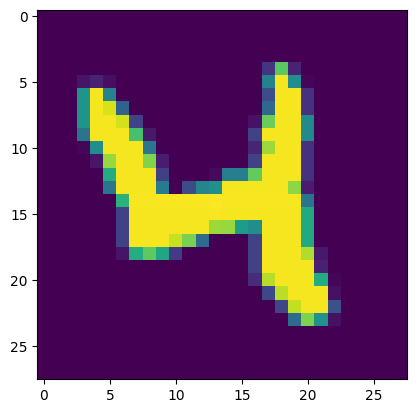

In [7]:
plt.imshow(x_train[20]), y_train[20]

In [8]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [9]:
class ImageNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.ReLU()
        self.l3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        return x

In [17]:
def print_accuracy(model, x_test, y_test):
    x_test = torch.tensor(x_test.reshape(-1, 28*28)).float()
    y_test = torch.tensor(y_test)
    # Model is trained now
    # Call it on Test Data and see the accuracy
    labels = model(x_test).argmax(1)
    accuracy = (labels == y_test).float().mean()
    print(f"Test Accuracy: {accuracy}")

## Training without Gradient Accumulation
Parameters: 
- Mini Batch Size (per forward pass) = 32

In [14]:
# Training without Gradient Accumulation
def train_without_grad_accum(model, x_train, y_train):
    # Data Preprocess
    x_train = torch.tensor(x_train.reshape(-1, 28*28)).float()
    y_train = torch.tensor(y_train)
    
    # Training Loop
    iters = 5000
    batch_size = 32
    optimizer = torch.optim.Adam(model.parameters())
    
    loss_fn = nn.CrossEntropyLoss()
    
    for i in (t := trange(iters)):
        # Batches
        ix = torch.randint(0, x_train.shape[0], (batch_size, ))
        x, y = x_train[ix], y_train[ix]
        
        # Forward pass
        out = model(x)
    
        # Calc Loss
        loss = loss_fn(out, y)
        
        accuracy = (torch.argmax(out, dim=1) == y).float().mean()
        t.set_description(f"loss: {loss.item()}, acc: {accuracy}")
    
        # Zero grad
        optimizer.zero_grad()
    
        # Backward Pass
        loss.backward()
    
        # Update Gradients
        optimizer.step()

In [19]:
model1 = ImageNet()
train_without_grad_accum(model1, x_train, y_train)
print_accuracy(model1, x_test, y_test)

loss: 0.08066586405038834, acc: 0.96875: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 723.30it/s]


Test Accuracy: 0.947700023651123


## Training with Gradient Accumulation
Parameters: 
- Mini Batch Size = 256
- Micro Batch Size (per forward pass) = 32
- Gradient Accumulation Steps = 8 (256 / 32)

One thing to keep in mind is that the averaged loss calculation has to be updated as the loss that comes out of `loss_fn` only computes the average based on micro_batch_size.
```
loss -> Averaged for 32 samples (micro batch), but the batch size to consider to compute the entire loss for the batch is 256.
updated_loss = loss / grad_accum_steps
```

In [20]:
# Training without Gradient Accumulation
def train_with_grad_accum(model, x_train, y_train):
    # Data Preprocess
    x_train = torch.tensor(x_train.reshape(-1, 28*28)).float()
    y_train = torch.tensor(y_train)
    
    # Training Loop
    iters = 5000
    batch_size = 256
    micro_batch_size = 32
    grad_accum_steps = batch_size // micro_batch_size
    optimizer = torch.optim.Adam(model.parameters())

    print(f"Mini Batch Size: {batch_size}, Micro Batch Size: {micro_batch_size}, Grad Accum Steps: {grad_accum_steps}")
    
    loss_fn = nn.CrossEntropyLoss()
    
    for i in (t := trange(iters)):
        # Zero grad
        optimizer.zero_grad()
        loss_accum = 0.0
        for step in range(grad_accum_steps):
            # Micro Batches
            ix = torch.randint(0, x_train.shape[0], (micro_batch_size, ))
            x, y = x_train[ix], y_train[ix]
            
            # Forward pass
            out = model(x)
        
            # Calc Loss
            loss = loss_fn(out, y)

            loss = loss / grad_accum_steps

            loss_accum += loss.detach()

            # Backward Pass
            loss.backward()

        t.set_description(f"loss: {loss_accum.item()}")

        # Update Weights only after Gradients are accumulated
        optimizer.step()

In [22]:
model2 = ImageNet()
train_with_grad_accum(model2, x_train, y_train)
# print_accuracy(model1, x_test, y_test)

Mini Batch Size: 256, Micro Batch Size: 32, Grad Accum Steps: 8


loss: 0.04732232913374901: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:18<00:00, 274.17it/s]


In [23]:
print_accuracy(model2, x_test, y_test)

Test Accuracy: 0.961899995803833


#### Note: Accuracy Increased with Bigger batch sizes per iteration